##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive')
%cd '/content/gdrive/MyDrive/EVA S9/EVA/S9'

Mounted at ./gdrive
/content/gdrive/MyDrive/EVA S9/EVA/S9


In [2]:
import torch
import torchvision
from torchsummary import summary
from matplotlib import pyplot as plt

In [3]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 37.6MB 76kB/s 
     |████████████████████████████████| 952kB 56.5MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import albumentations as A
from utils import DataProcessing
from regularizations import Regularizations
from model import *
from graphs import Graphs
from train import *
from test import *
from AlbumentationTransformations import  AlbumentationTransforms as AT
from albumentations.pytorch import ToTensorV2


## Maintaining Reproducability

In [5]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [6]:
data = DataProcessing('CIFAR10')


In [7]:
train_set = data.Dataset('./Data', True, True, AT([A.HorizontalFlip(), A.pytorch.ToTensor()]))
test_set = data.Dataset('./Data', False, True, AT([A.HorizontalFlip(), A.pytorch.ToTensor()]))


Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
train_set[0]

(tensor([[[0.5804, 0.5961, 0.6196,  ..., 0.1961, 0.1686, 0.2314],
          [0.4784, 0.4667, 0.4824,  ..., 0.0706, 0.0000, 0.0627],
          [0.4275, 0.4706, 0.4627,  ..., 0.1922, 0.0627, 0.0980],
          ...,
          [0.2078, 0.2196, 0.6275,  ..., 0.7765, 0.7882, 0.8157],
          [0.3255, 0.3804, 0.7216,  ..., 0.7294, 0.6784, 0.7059],
          [0.4824, 0.5922, 0.8471,  ..., 0.7020, 0.6588, 0.6941]],
 
         [[0.4863, 0.4902, 0.5176,  ..., 0.1882, 0.1804, 0.2431],
          [0.3412, 0.3255, 0.3451,  ..., 0.0314, 0.0000, 0.0784],
          [0.2863, 0.3294, 0.3294,  ..., 0.1059, 0.0275, 0.0941],
          ...,
          [0.1333, 0.1216, 0.5216,  ..., 0.6314, 0.6000, 0.6667],
          [0.2078, 0.2431, 0.5804,  ..., 0.5647, 0.4824, 0.5451],
          [0.3608, 0.4627, 0.7216,  ..., 0.5569, 0.5059, 0.5647]],
 
         [[0.4039, 0.4000, 0.4235,  ..., 0.1686, 0.1765, 0.2471],
          [0.2235, 0.1961, 0.2157,  ..., 0.0000, 0.0000, 0.0784],
          [0.1647, 0.1961, 0.1961,  ...,

'truck'

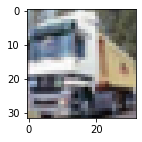

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(train_set[1][0],(1,2,0)))
train_set.classes[train_set[1][1]]


In [11]:
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

## Taking a sneak peek at the dataset

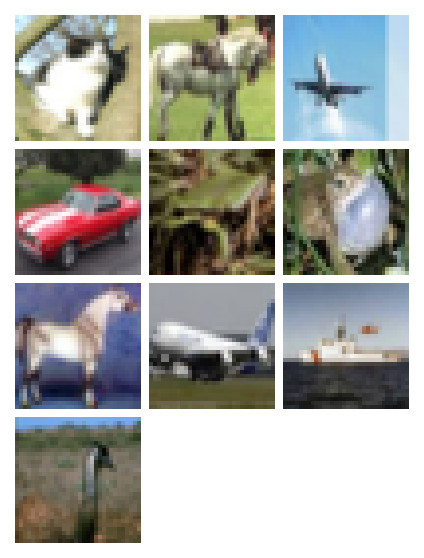

['cat', 'horse', 'airplane', 'automobile', 'frog', 'frog', 'horse', 'airplane', 'ship', 'bird']


In [28]:
plt.figure(figsize=(10,10))
batch = next(iter(train_loader))
images, labels = batch
image, label = [],[]
for i in range(10):
  image.append(images[i])
  label.append(train_set.classes[labels[i]])

grid = torchvision.utils.make_grid(image, nrow=3, pad_value=1.0)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [13]:
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = ResNet18().to(device) 
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

##Loading the object for different regularizations

In [14]:
regularizer = Regularizations('SGD', model, 0.01, 0.9, 6, 0.1)

## Defining the main sequence of training and testing the model using the imported modules

In [15]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    regularizer.optimizer_step(step=True)
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [16]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(25, model, device, train_loader, regularizer, test_set, test_loader)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.020470925 
Train Accuracy :  52.9320% 

Average Test Loss : 0.016380536 
Test Accuracy :  63.6700% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.012303385 
Train Accuracy :  72.3120% 

Average Test Loss : 0.012105602 
Test Accuracy :  72.8400% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.009390658 
Train Accuracy :  79.2060% 

Average Test Loss : 0.009500507 
Test Accuracy :  79.5400% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.007527593 
Train Accuracy :  83.3860% 

Average Test Loss : 0.009017306 
Test Accuracy :  80.6600% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.006299415 
Train Accuracy :  86.0180% 

Average Test Loss : 0.008949717 
Test Accuracy :  81.2800% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.005333700 
Train Accuracy :  88.2100% 

Average Test Loss : 0.008729010 
Test Accuracy :  82.0600% 


Epoch 7 in progress....

Epo

## Plotting the graph for the logged results

In [17]:
graphs = Graphs('Validation Loss', 'Validation Accuracy')


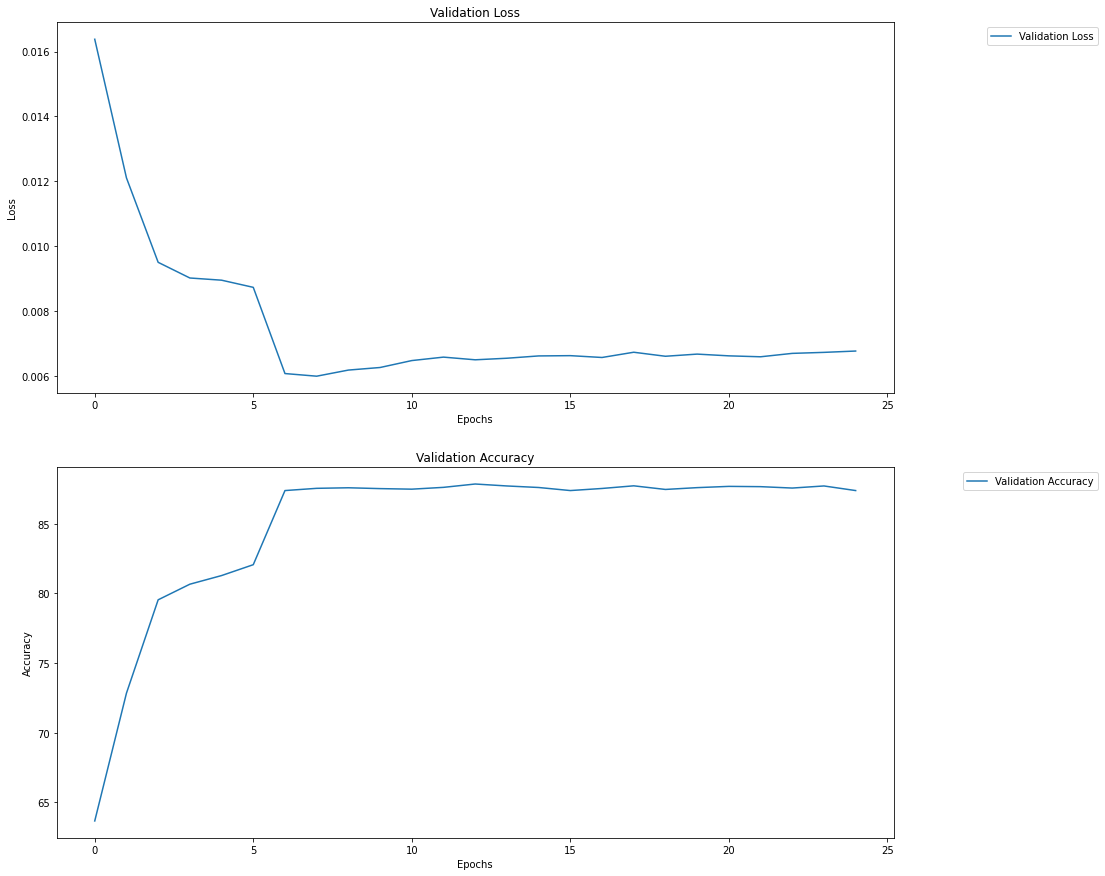

In [18]:
graphs.line_graph((15,15), test_losses, test_accuracies)


## Plotting 25 Misclassified Predictions

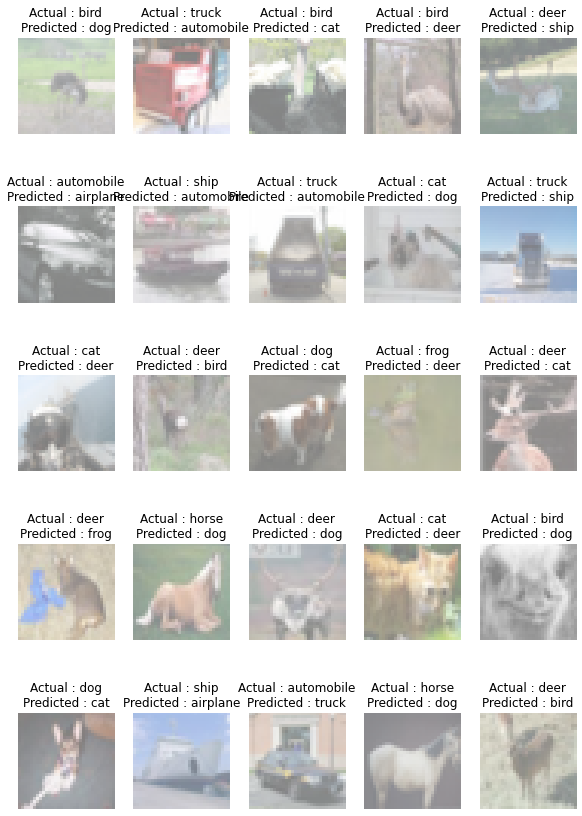

In [19]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])